# Step 3: Visualization for Slowloris vs. Benign Traffic

This notebook:
1. Loads the filtered Slowloris and Benign data.
2. Creates a binary target column.
3. Selects candidate features for analysis.
4. Generates a correlation heatmap.
5. Computes tree-based feature importance using Random Forest.
6. Summarizes findings.

In [15]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Ensure plots appear inline
%matplotlib inline

In [16]:
# 2. Load Slowloris and Benign Data
import os, glob
split_dir = "./split_by_label"
csv_files = glob.glob(os.path.join(split_dir, "*.csv"))
print("Files found for analysis:", csv_files)

data_list = [pd.read_csv(f) for f in csv_files]
data = pd.concat(data_list, ignore_index=True)
print("Combined data shape:", data.shape)
print("Labels present:", data['label'].unique())

Files found for analysis: ['./split_by_label/DDoS-SlowLoris.csv', './split_by_label/BenignTraffic.csv']
Combined data shape: (1121621, 47)
Labels present: ['DDoS-SlowLoris' 'BenignTraffic']


In [17]:
# 3. Create Binary Target Column for Slowloris
data['is_slowloris'] = (data['label'] == 'DDoS-SlowLoris').astype(int)
print("Unique values in 'is_slowloris':", data['is_slowloris'].unique())

Unique values in 'is_slowloris': [1 0]


In [18]:
# 4. Select Candidate Features
candidate_features = [
    "flow_duration", "Rate", "Srate", "Drate",
    "syn_flag_number", "ack_flag_number",
    "IAT", "Number", "Magnitue", "Radius",
    "Variance", "Weight"
]

# Verify feature presence
missing = [f for f in candidate_features if f not in data.columns]
if missing:
    print("Warning: Missing features:", missing)
else:
    print("All candidate features are present.")

All candidate features are present.


In [19]:
# Automatically remove constant columns
non_constant = [col for col in candidate_features 
                if data[col].nunique() > 1]
print("Using features:", non_constant)

corr_df = data[non_constant + ['is_slowloris']].corr()

Using features: ['flow_duration', 'Rate', 'Srate', 'syn_flag_number', 'ack_flag_number', 'IAT', 'Number', 'Magnitue', 'Radius', 'Variance', 'Weight']


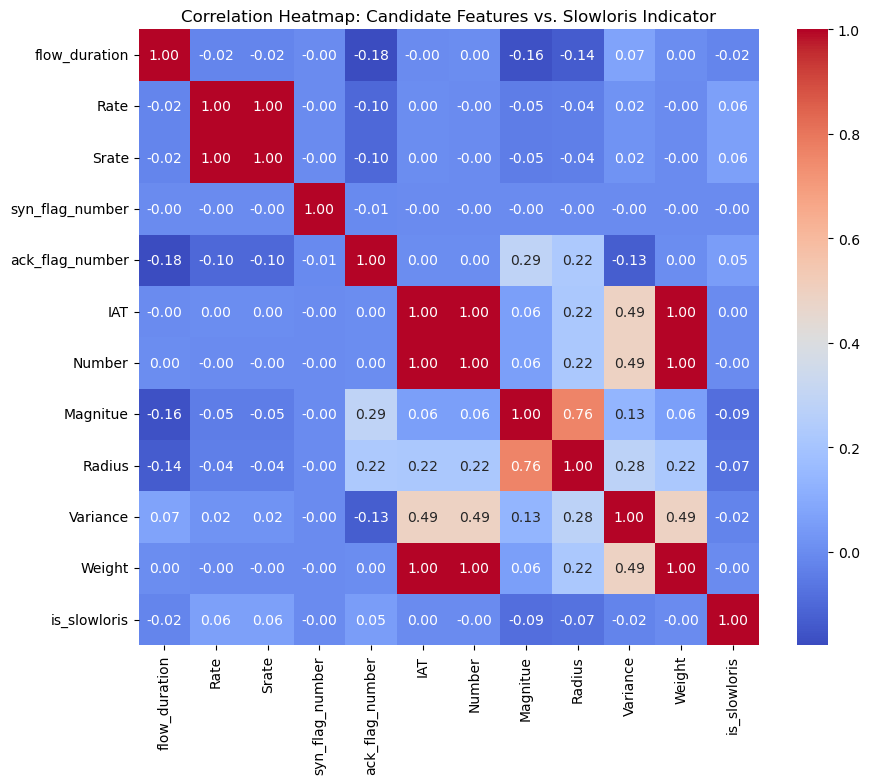

In [20]:
# 5. Correlation Heatmap
# corr_df = data[candidate_features + ['is_slowloris']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Candidate Features vs. Slowloris Indicator")
plt.show()

Tree-based Feature Importance:


,Feature,Importance
11,Weight,0.290072
7,Number,0.260235
6,IAT,0.253294
10,Variance,0.117527
1,Rate,0.022469
2,Srate,0.021385
0,flow_duration,0.014733
9,Radius,0.009261
8,Magnitue,0.007085
5,ack_flag_number,0.003940


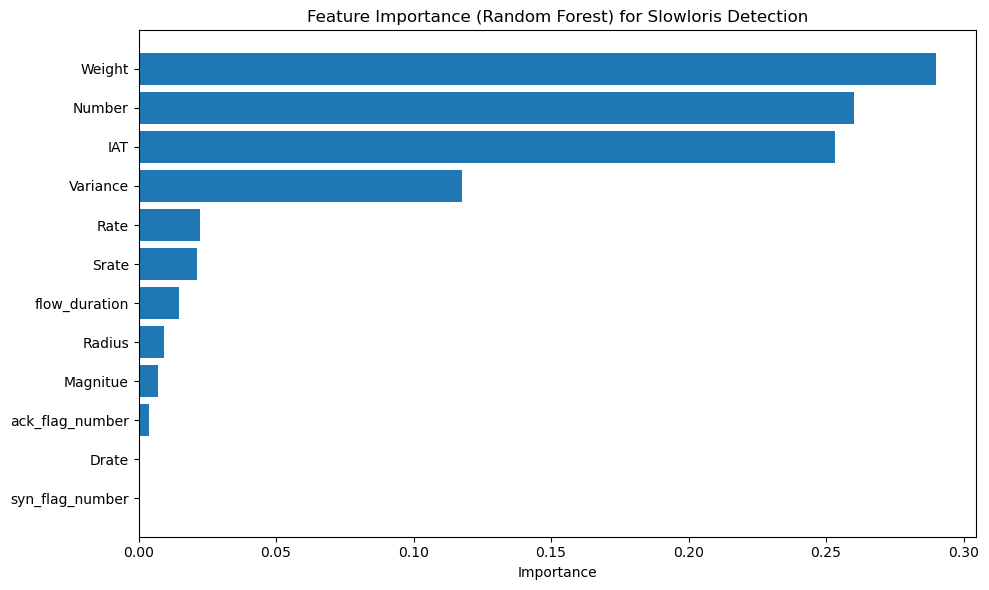

In [21]:
# 6. Tree-based Feature Importance with Random Forest
# Sample if large
if len(data) > 10000:
    sample_df = data.sample(n=10000, random_state=42)
else:
    sample_df = data.copy()

X = sample_df[candidate_features]
y = sample_df['is_slowloris']

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': candidate_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Tree-based Feature Importance:")
display(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest) for Slowloris Detection")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Conclusion:**

- The correlation heatmap reveals which features most strongly correlate with Slowloris attacks.
- The Random Forest importance ranking highlights key predictors for the binary classification of Slowloris vs. Benign.